In [1]:
import networkx as nx
import pickle
import numpy as np
from pathlib import Path
import pandas as pd
import os

import sys
sys.path.append("../src")
from data_component import DataComponent
from graph_utils import *


In [2]:
# ~2 min
data = DataComponent(real_data="Brexit")


Opinions stats 
mean: 0.5483296179151699
std: 0.40122325342413656
min: 0.0
max: 1.0


Text(0, 0.5, 'occurrences')

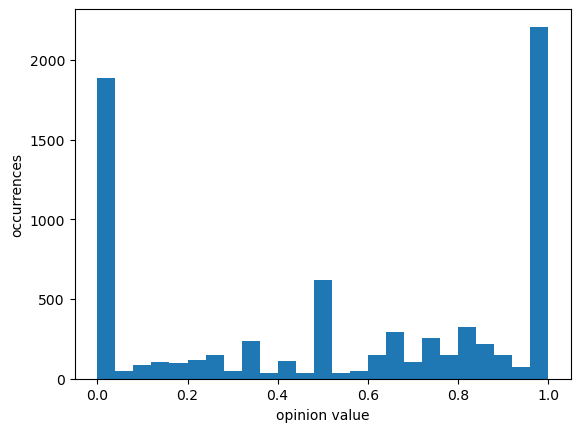

In [3]:
opinions = data.get_opinions()
print(f'Opinions stats \nmean: {opinions.mean()}\nstd: {opinions.std()}\nmin: {opinions.min()}\nmax: {opinions.max()}')

import matplotlib.pyplot as plt
_ = plt.hist(opinions, bins=25, range=[0,1])
plt.xlabel('opinion value')
plt.ylabel('occurrences')


In [5]:
G_brexit = data.get_graph()


In [6]:
edges_to_remove = []
gaps = []
edges = G_brexit.edges()
for edge in edges:
    i, j = edge
    if i == j:
        continue
    gaps.append(abs(opinions[i]-opinions[j]))
    if (not (opinions[i] >= 0.5 and opinions[j] >= 0.5)) and (not (opinions[i] < 0.5 and opinions[j] < 0.5)):
        edges_to_remove.append(edge)
        

In [7]:
len(edges_to_remove)/len(edges)


0.28203110474233695

In [8]:
G_brexit_reduced = G_brexit.copy()
G_brexit_reduced.remove_edges_from(edges_to_remove)


In [9]:
import networkx as nx
import community as community_louvain
import numpy as np
from collections import defaultdict

def analyze_communities(G, G_raw, opinions, metric_type, min_community_size=100):
    # Compute the best partition using Louvain method on graph G
    partition = community_louvain.best_partition(nx.Graph(G))
    
    # Initialize dictionaries to store results
    community_nodes_count = defaultdict(int)
    community_opinion_avg = {}

    # Calculate the number of nodes in each community and their average opinion
    for node, comm in partition.items():
        community_nodes_count[comm] += 1
        if comm not in community_opinion_avg:
            community_opinion_avg[comm] = []
        community_opinion_avg[comm].append(opinions[node])

    # Calculate average opinions and filter communities
    large_communities = {comm: nodes for comm, nodes in community_nodes_count.items() if nodes >= min_community_size}
    community_avg_opinions = {comm: np.mean(community_opinion_avg[comm]) for comm in large_communities.keys()}

    # Identify the community with the highest or lowest average opinion based on metric
    target_comm = None
    if metric_type == "positive-central" or metric_type == "positive-high-degree" or metric_type == "positive-lowest-degree":
        target_comm = max(community_avg_opinions, key=community_avg_opinions.get)
    elif metric_type == "negative-central" or metric_type == "negative-high-degree" or metric_type == "negative-lowest-degree":
        target_comm = min(community_avg_opinions, key=community_avg_opinions.get)

    # Get the nodes in the target community
    nodes_in_target_comm = [node for node, community in partition.items() if community == target_comm]

    if metric_type in ["positive-central", "negative-central"]:
        # Calculate centrality in G_raw
        centrality = nx.degree_centrality(G_raw)
    elif metric_type in ["positive-high-degree", "negative-high-degree", "positive-lowest-degree", "negative-lowest-degree"]:
        # Calculate degree in G_raw
        centrality = dict(G_raw.degree(nodes_in_target_comm))

    # Identify the node with the highest or lowest centrality/degree
    target_node = None
    if metric_type == "positive-central":
        target_node = max(nodes_in_target_comm, key=lambda node: centrality[node])
    elif metric_type == "negative-central":
        target_node = max(nodes_in_target_comm, key=lambda node: centrality[node])
    elif metric_type == "positive-high-degree":
        target_node = max(nodes_in_target_comm, key=lambda node: centrality[node])
    elif metric_type == "negative-high-degree":
        target_node = max(nodes_in_target_comm, key=lambda node: centrality[node])
    elif metric_type == "positive-lowest-degree":
        target_node = min((node for node in nodes_in_target_comm if centrality[node] > 1), key=lambda node: centrality[node], default=None)
    elif metric_type == "negative-lowest-degree":
        target_node = min((node for node in nodes_in_target_comm if centrality[node] > 1), key=lambda node: centrality[node], default=None)

    return target_node, large_communities, community_avg_opinions, partition
    

In [10]:
# Choose:
# "positive-central": i.e., MOST central in  the most positive community
# "negative-central": i.e., MOST central in  the most negative community
# "positive-high-degree": i.e., MAX out-degree in the most positive community
# "negative-high-degree": i.e., MAX out-degree in the most negative community
# "positive-lowest-degree": i.e., out-degree > 1
# "negative-lowest-degree": i.e., out-degree > 1
nodeid, communities, community_avg_opinions, partition = analyze_communities(G_brexit_reduced, G_brexit, opinions, metric_type="positive-central")


In [11]:
nodeid

3638

In [12]:
communities

{0: 3118, 1: 2894, 2: 1326}

In [13]:
community_avg_opinions

{0: 0.8561698127385479, 1: 0.09385165519752996, 2: 0.7990384509538939}

In [14]:
partition[nodeid] == 0

True